In [1]:
import numpy as np
from scipy.sparse.linalg import spsolve, LinearOperator
from scipy.sparse import csc_matrix
import matplotlib.pyplot as plt
import scipy

## Задания 

1. Реализуйте функцию, вычисляющую $Ax$, где $A$ -\- вышеуказанная дискретизация оператора Лапласса.
Реализуйте функцию, вычисляющую $A^Tx$ на произвольном векторе $x$.

2. Решите дискретизованное уравнение Пуассона выше с помощью функции [`scipy.sparse.linalg.spsolve`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.spsolve.html). 

In [2]:
N = 10
h=1/N

In [3]:
def vec_b(n): #1d
    def b(i,j,k):
        return (i/N - 1/2)**2 + (j/N - 1/2)**2 + (k/N - 1/2)**2
    
    vec = np.zeros((n,n,n))
    for i in range(n):
        for j in range(n):
            for k in range(n):
                vec[i,j,k] = b(i,j,k)
    return vec.flatten()

In [4]:
def A(x): #x - 1d
    n = int(np.around((x.shape[0])** (1. / 3)))
    x = x.reshape((n,n,n)) # x - 3d
    zer = np.zeros((n+2,n+2,n+2)) 
    zer[1:-1,1:-1,1:-1] = x[:,:,:] #добавляем 0 границы вокруг искомой области
    y = np.empty_like(x)
    for i in range(1,n+1):
        for j in range(1,n+1):
            for k in range(1,n+1):
                y[i-1,j-1,k-1] = zer[i+1,j,k] + zer[i-1,j,k] + zer[i,j+1,k] + zer[i,j-1,k] + zer[i,j,k+1] + zer[i,j,k-1] - 6*zer[i,j,k]
#                 y[i,j,k] = 10 * np.sin(i*np.pi/(N-1)) * np.sin(j*np.pi/(N-1))*np.sin(k*np.pi/(N-1))
    y = y*(n**2)
    return y.flatten()

In [5]:
Oper = LinearOperator(matvec = A, shape=((N)**3,(N)**3))

In [6]:
Oper_mat = Oper * np.eye(N**3) #получаем матричный вид оператора
Oper_mat_sparse = csc_matrix(Oper_mat) #переводим в разреженный вид
Bvec = vec_b(N)

In [7]:
sol = spsolve(Oper_mat_sparse,Bvec.T)

In [8]:
sol = sol.reshape((N,N,N))
sol1 = np.zeros((N,N,N))
sol1[1:-1,1:-1,1:-1] = sol[1:-1,1:-1,1:-1]

# Задания

3. Какова размерность пространства $K(A,b,m)$, если $A$ - дискретизация лаплассиана, определенная выше?

4. Запишите матрицу $\tilde A_m$ сужения оператора $A$ на пространство Крылова $K(A,b,m)$ в базисе $e_k$:
$$e_0=b,\quad e_1=Ae_0,\quad e_{k+1}=Ae_k.$$
Как раскладывается $Ae_{m-1}$ по векторам $e_0,\ldots,e_{m-1}$?

5. Найдите проекцию $\tilde b$ вектора $b$ на подпространство Крылова $K(A,b,m)$ и решите систему $\tilde A_m \tilde x=\tilde b$
из $m$ уравнений.
Вложите вектор $\tilde x$ обратно в $N^3$ мерное пространство и оцените погрешность решения уравнения $Ax=b$. 

Размерность вектора $b - N^3$, $Ab - N^3$, $K(A,b,m) - m N^3$.

In [9]:
def Krylov_basis(A, b, m):
    sizes = b.shape
    b = b.flatten()
    E = np.zeros((b.shape[0],m))
    E[:,0] = b[:]
    vec = np.zeros((b.shape[0],))
    for k in range(1,m):
        vec[:] = E[:,k-1]
        n_vec = A @ vec
        E[:, k] = n_vec[:]
    return E

In [10]:
m = 10
S = Krylov_basis(Oper_mat, Bvec, m)

In [11]:
A_kr = np.linalg.pinv(S) @ Oper_mat @ S

In [12]:
P_kr = S @ (np.linalg.pinv(S.T @ S)) @ S.T
# P_kr @ Bvec

In [13]:
b_kr = np.linalg.solve(S[:m,:m],Bvec[:m])

In [14]:
b_kr

array([1.00000000e+00, 8.27602687e-15, 2.17858489e-16, 2.51153203e-18,
       1.56467137e-20, 5.57044712e-23, 1.14555174e-25, 1.33230836e-28,
       8.08596986e-32, 1.98188863e-35])

In [15]:
sol_kr = np.linalg.solve(A_kr,b_kr)
sol_kr = (S @ sol_kr).reshape((N,N,N))

In [16]:
np.amax(sol - sol_kr)

-2.7566885276277403e+32

## Задания
6. Реализуйте метод Ланцоша и найдите ортонормированный базис в пространстве $K(A,b,m)$.
Убедитесь, что матрица $A_m$ оператора $A$ в этом базисе трехдиагональна.

7. Найдите разложение $b_m$ вектора $b$ по построенному базису и решите систему $A_m x_m=b_m$.
Вложите вектор $x_m$ обратно в $N^3$-мерное пространство и найдите ошибку решения. 
Сравните решение с полученным в задании 5.
 

In [17]:
def Lanczos(A, b, n: int):

    m = A.shape[0]
    H = np.zeros((n + 1, n))
    Q = np.zeros((m, n + 1))
    q = b / np.linalg.norm(b)  
    Q[:, 0] = q  

    for k in range(n):
        v = A @ q  
        for j in range(k + 1):  
            H[j, k] = Q[:, j] @ v
            v = v - H[j, k] * Q[:, j]

        H[k + 1, k] = np.linalg.norm(v)
        eps = 1e-15  
        if H[k + 1, k] > eps:  
            q = v / H[k + 1, k]  
            Q[:, k + 1] = q
        else: 
            return Q, H
    return Q[0:m, 0:n] , H[0:n, 0:n]

In [18]:
S_ort, h = Lanczos(Oper_mat, Bvec, n = 20)

In [19]:
A_kr_ort = S_ort.T @ Oper_mat @ S_ort

In [20]:
b_kr_ort = S_ort.T @ Bvec

In [21]:
sol_kr_ort = np.linalg.solve(A_kr_ort,b_kr_ort)
sol_kr_ort = (S_ort @ sol_kr_ort).reshape((N,N,N))

In [22]:
np.linalg.norm(sol_kr - sol_kr_ort)

3.043345031952529e+36

## Задания

8. Используйте $K=K(A,b,m)$, $L=A K$ и решите уравнение Пуассона метода Петрова-Галеркина. 
Оцените ошибку получившегося решения.
Получающийся метод имеет название [GMRES](https://en.wikipedia.org/wiki/Generalized_minimal_residual_method).
Убедитесь, что этот подход минимизирует невязку по всем $x\in K$.

9. Оцените время работы алгоритма как функцию от $m$.

In [23]:
K = S
L = Oper_mat @ K

In [24]:
def gmres(A, b, x0, m):
 
    r0 = b - A @ x0
    beta = np.linalg.norm(r0)
    x=[]
    x.append(r0)
    V = np.zeros((r0.shape[0],m))
    W = np.zeros((r0.shape[0],m))
    V[:,0] = r0[:]/beta
    H = np.zeros((m+1,m))
    Beta_arr = np.zeros(m+1)
    Beta_arr[0] = beta
    for j in range(m):
        W[:,j] = A @ V[:,j]
        for i in range(j):
            H[i,j] = W[:,j] @ V[:,i]
            W[:,j] -= H[i,j] * V[:,i]
        H[j+1,j] = np.linalg.norm(W[:,j])
        if (H[j+1,j] != 0) and (j != m-1):
            V[:,j+1] = W[:,j]/H[j+1,j]
    
        
        y = np.linalg.lstsq(H, Beta_arr)[0]
        x.append(x0 + V@y)
    return x[m-1]

In [25]:
xx = gmres(Oper_mat, Bvec, Bvec, 10)
xx = xx.reshape((N,N,N))

<ipython-input-24-2c46e6fa4c05>:23: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  y = np.linalg.lstsq(H, Beta_arr)[0]


In [26]:
ans = scipy.sparse.linalg.gmres(Oper_mat, Bvec, Bvec)[0]
ans = ans.reshape((N,N,N))

In [27]:
np.linalg.norm(ans - sol)

1.3157681064998586e-06

In [28]:
import time
def ftime(f, *args, n_iter=5):
    acc = float('inf')
    for i in range (n_iter):
        t0 = time.perf_counter()
        f(*args)
        t1 = time.perf_counter()
        acc = min(acc,t1-t0)
    return acc

In [29]:
t = []
for n in range(10,300,10):
    t.append(ftime(gmres, Oper_mat, Bvec, Bvec, 10))

<ipython-input-24-2c46e6fa4c05>:23: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  y = np.linalg.lstsq(H, Beta_arr)[0]


Text(0, 0.5, 'Время работы GMRes, s')

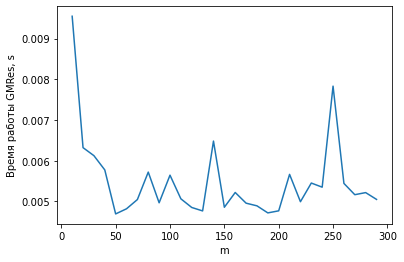

In [30]:
plt.plot(list(range(10,300,10)), t)
plt.xlabel("m")
plt.ylabel("Время работы GMRes, s")

## Задание

11. Используйте метод Ланцоша для построения трехдиагональной матрицы сужения оператора $A$ на пространство Крылова $K(A,q,m)$
для некоторого вектора $q$.
Найдите наименьшее собственное значение трехдиагональной матрицы и сравните с наименьшим собственным значением оператора Лапласа.
Изучите, как изменяется ошибка, как функция от размерности $m$ пространства Крылова.

In [35]:
l, vec = np.linalg.eigh(Oper_mat)
min_egiv = np.min(l)
print('Min собственное значение: ',min_egiv)

Min собственное значение:  -1175.6957841686985


In [32]:
hist = []
b = np.zeros(N**3)
b[4] = 1.

In [33]:
for i in range(2, 45):
    Q, H = Lanczos(Oper_mat, Bvec, i)
    l, vec = np.linalg.eigh(H)
    hist.append(np.min(l) - min_egiv)

Text(0, 0.5, 'логарифм модуля ошибки')

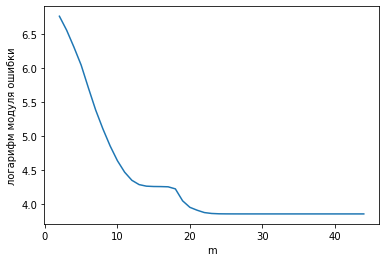

In [34]:
plt.plot(list(range(2, 45)), np.log(np.abs(hist)))
plt.xlabel("m")
plt.ylabel("логарифм модуля ошибки")